In this notebook, let's consider all the functionalities of langchain under the lense of how to be a more productive researcher.

# Leveraging Code Executionm

In [1]:
!pip install langchain
!pip install langchain-core
!pip install langchain-community
!pip install langchain-experimental
!pip install langchain-openai
!pip install duckduckgo-search
!pip install xmltodict

In [2]:
import os

# # Set OPENAI API Key

os.environ["OPENAI_API_KEY"] = "your openai key"

# OR (load from .env file)

# from dotenv import load_dotenv
# load_dotenv("./.env")

True

In [1]:
from langchain_openai import ChatOpenAI

from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema.output_parser import StrOutputParser

from langchain_experimental.utilities import PythonREPL

ImportError: cannot import name 'LangSmithParams' from 'langchain_core.language_models.chat_models' (/Users/greatmaster/miniconda3/envs/oreilly-langchain/lib/python3.11/site-packages/langchain_core/language_models/chat_models.py)

In [2]:
template = """Write some python code to solve the user's problem. 

Return only python code in Markdown format, e.g.:

```python
....
```"""
prompt = ChatPromptTemplate.from_messages([("system", template), ("human", "{input}")])

model = ChatOpenAI()

In [3]:
def _sanitize_output(text: str):
    _, after = text.split("```python")
    return after.split("```")[0]

In [4]:
chain = prompt | model | StrOutputParser() | _sanitize_output | PythonREPL().run

In [5]:
chain.invoke({"input": "whats 2 plus 2"})

Python REPL can execute arbitrary code. Use with caution.


'4\n'

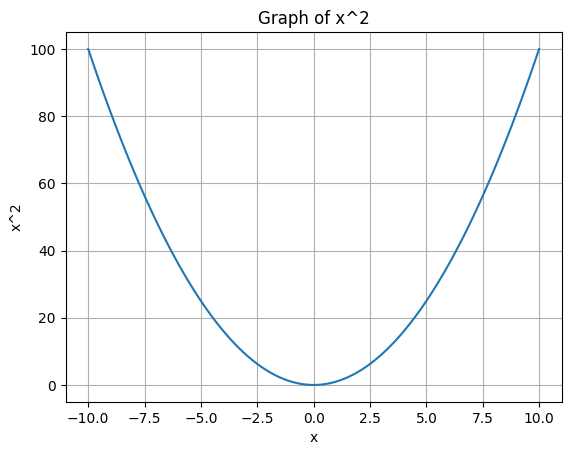

''

In [7]:
chain.invoke({"input": "Plot a graph of x squared"})

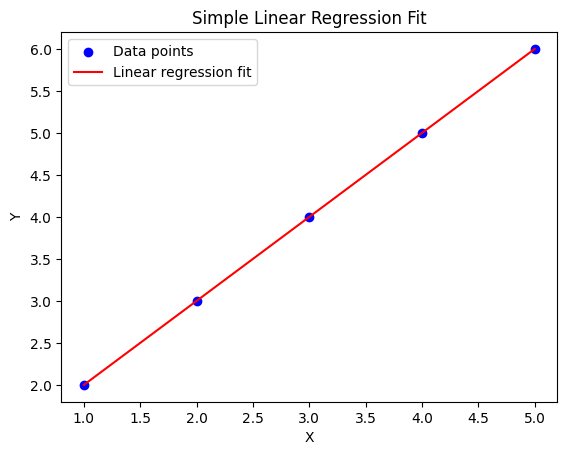

''

In [8]:
chain.invoke({"input": "Plot a simple linear regression fit over some toy example data, use numpy and not sklearn"})

# Leveraging Tools

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.tools import DuckDuckGoSearchRun

In [10]:
search = DuckDuckGoSearchRun()

In [11]:
template = """turn the following user input into a search query for a search engine:

{input}"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI()

In [12]:
chain = prompt | model | StrOutputParser() | search

In [15]:
output = chain.invoke({"input": "What is a transformer architecture in the context of Artificial neural networks?"})

In [16]:
from IPython.display import Markdown


Markdown(output)

The transformer neural network is a novel architecture that aims to solve sequence-to-sequence tasks while handling long-range dependencies with ease. It was first proposed in the paper "Attention Is All You Need" and is now a state-of-the-art technique in the field of natural language processing (NLP). Before jumping into the transformer network, I will explain why we use it and where it ... Transformer neural network architecture has a set of traits that make it a suitable architecture for those domains: it is expressive, plays well with current optimization techniques, and it can be parallized. From those traits, one can say that transformer is an efficient architecture. That said however, the efficiency of transformer comes with ... A transformer is a type of neural network architecture capable of learning context and relationships from sequential data such as text. This makes it applicable to a wide range of natural language processing (NLP) tasks such as: ... Consequently, the transformer architecture makes efficient use of a GPU's processing abilities and is more ... Transformer is a neural network architecture that makes use of self-attention. It replaces earlier approaches of LSTMs or CNNs that used attention between encoder and decoder. Transformer showed that a feed-forward network used with self-attention is sufficient. Influential language models such BERT and GPT-2 are based on the transformer ... What are transformer models? The transformer (represented by the T in ChatGPT, GPT-2, GPT-3, GPT-3.5, etc.) is the key element that makes generative AI so, well, transformational. Transformer models are a type of neural network architecture designed to process sequential material, such as sentences or time-series data.

# Extracting Structured Information with Playwright

In [13]:
# see scripts in dev-scripts-playwright-langchain.py

# Automating Literature Review with LangChain

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")

In [38]:
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent, load_tools
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
tools = load_tools(
    ["arxiv"],
)
prompt = hub.pull("hwchase17/react")

agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [39]:
agent_executor.invoke(
    {
        "input": "Latest top 3 papers about Large Language Models",
    }
)



> Entering new AgentExecutor chain...
I should search for the latest papers on Large Language Models on arxiv.org to find the top 3 papers.

Action: arxiv
Action Input: Large Language ModelsPublished: 2023-06-12
Title: Lost in Translation: Large Language Models in Non-English Content Analysis
Authors: Gabriel Nicholas, Aliya Bhatia
Summary: In recent years, large language models (e.g., Open AI's GPT-4, Meta's LLaMa,
Google's PaLM) have become the dominant approach for building AI systems to
analyze and generate language online. However, the automated systems that
increasingly mediate our interactions online -- such as chatbots, content
moderation systems, and search engines -- are primarily designed for and work
far more effectively in English than in the world's other 7,000 languages.
Recently, researchers and technology companies have attempted to extend the
capabilities of large language models into languages other than English by
building what are called multilingual language mod

{'input': 'Latest top 3 papers about Large Language Models',
 'output': 'The latest top 3 papers about Large Language Models are:\n1. "Lost in Translation: Large Language Models in Non-English Content Analysis" by Gabriel Nicholas and Aliya Bhatia (2023-06-12)\n2. "Cedille: A large autoregressive French language model" by Martin Müller and Florian Laurent (2022-02-07)\n3. "How Good are Commercial Large Language Models on African Languages?" by Jessica Ojo and Kelechi Ogueji (2023-05-11)'}

To automate literature review with Langchain, you can use the PubMedRetriever and PubMedLoader modules. Here's how you can do it:

• Install the required packages:

In [20]:
# Import the necessary modules:

from langchain.retrievers import PubMedRetriever #for the PubMedRetriever module.
from langchain.document_loaders import PubMedLoader #for the PubMedLoader module.

In [21]:
#• Create an instance of the PubMedRetriever:

retriever = PubMedRetriever()

In [23]:
# Use the PubMedRetriever to get relevant documents based on a search query:

query = "neuroplasticity"
docs = retriever.invoke(query)
docs

[Document(page_content='Enteric neuropathies are characterized by abnormalities of gut innervation, which includes the enteric nervous system, inducing severe gut dysmotility among other dysfunctions. Most of the gastrointestinal tract is innervated by the vagus nerve, the efferent branches of which have close interconnections with the enteric nervous system and whose afferents are distributed throughout the different layers of the digestive wall. The vagus nerve is a key element of the autonomic nervous system, involved in the stress response, at the interface of the microbiota-gut-brain axis, has anti-inflammatory and prokinetic properties, modulates intestinal permeability, and has a significant capacity of plasticity and regeneration. Targeting these properties of the vagus nerve, with vagus nerve stimulation (or non-stimulation/ pharmacological methods), could be of interest in the therapeutic management of enteric neuropathies.', metadata={'uid': '38873822', 'Title': 'Enteric neu

In [24]:

# • Create an instance of the PubMedLoader:

loader = PubMedLoader(query)

# Load the documents using the PubMedLoader:

docs = loader.load()

In [25]:
# You can now access the loaded documents and their metadata:

docs #to access the metadata of the first document.

[Document(page_content='Enteric neuropathies are characterized by abnormalities of gut innervation, which includes the enteric nervous system, inducing severe gut dysmotility among other dysfunctions. Most of the gastrointestinal tract is innervated by the vagus nerve, the efferent branches of which have close interconnections with the enteric nervous system and whose afferents are distributed throughout the different layers of the digestive wall. The vagus nerve is a key element of the autonomic nervous system, involved in the stress response, at the interface of the microbiota-gut-brain axis, has anti-inflammatory and prokinetic properties, modulates intestinal permeability, and has a significant capacity of plasticity and regeneration. Targeting these properties of the vagus nerve, with vagus nerve stimulation (or non-stimulation/ pharmacological methods), could be of interest in the therapeutic management of enteric neuropathies.', metadata={'uid': '38873822', 'Title': 'Enteric neu

In [26]:
docs[0].page_content #to access the content of the first document.

#By using the PubMedRetriever and PubMedLoader modules, you can automate the process of retrieving and loading relevant literature for your literature review.

'Enteric neuropathies are characterized by abnormalities of gut innervation, which includes the enteric nervous system, inducing severe gut dysmotility among other dysfunctions. Most of the gastrointestinal tract is innervated by the vagus nerve, the efferent branches of which have close interconnections with the enteric nervous system and whose afferents are distributed throughout the different layers of the digestive wall. The vagus nerve is a key element of the autonomic nervous system, involved in the stress response, at the interface of the microbiota-gut-brain axis, has anti-inflammatory and prokinetic properties, modulates intestinal permeability, and has a significant capacity of plasticity and regeneration. Targeting these properties of the vagus nerve, with vagus nerve stimulation (or non-stimulation/ pharmacological methods), could be of interest in the therapeutic management of enteric neuropathies.'

In [27]:
len(docs)

3

In [28]:
from langchain.tools import PubmedQueryRun

In [29]:
tool = PubmedQueryRun()

In [30]:
tool.run("chatgpt")

"Published: 2024-05-30\nTitle: Assessing the utility of artificial intelligence throughout the triage outpatients: a prospective randomized controlled clinical study.\nCopyright Information: Copyright © 2024 Liu, Lai, Wu, Yan, Gan, Yang, Zeng, Liu, Liao, Lin, Jing and Zhang.\nSummary::\np\nCurrently, there are still many patients who require outpatient triage assistance. ChatGPT, a natural language processing tool powered by artificial intelligence technology, is increasingly utilized in medicine. To facilitate and expedite patients' navigation to the appropriate department, we conducted an outpatient triage evaluation of ChatGPT. For this evaluation, we posed 30 highly representative and common outpatient questions to ChatGPT and scored its responses using a panel of five experienced doctors. The consistency of manual triage and ChatGPT triage was assessed by five experienced doctors, and statistical analysis was performed using the Chi-square test. The expert ratings of ChatGPT's ans

With duck duck go search

In [31]:
import requests
from bs4 import BeautifulSoup
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.openai_functions.extraction import create_extraction_chain_pydantic
from langchain.agents import load_tools, AgentExecutor
import pandas as pd

In [32]:
def parse_html(content):
    soup = BeautifulSoup(content, 'html.parser')
    text_content_with_links = soup.get_text()
    return text_content_with_links

def fetch_web_page(url):
    response = requests.get(url)
    return parse_html(response.content)

In [33]:
tools = load_tools(["arxiv"])
prompt = hub.pull("hwchase17/react")
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [34]:
output = agent_executor.invoke({"input": "Research any 3 papers about large language models and output a json object containing title, abstract and citation, the\
    structure should be as follows: {title: ..., abstract: ..., citation: ...}. You will use the arxiv search engine to find the papers. The output should ONLY BE JSON. \n\n OUTPUT:\n\n"})



> Entering new AgentExecutor chain...
I need to search for papers on large language models on arxiv.
Action: arxiv
Action Input: large language modelsNo good Arxiv Result was foundI should try a more specific search query.
Action: arxiv
Action Input: "large language models"No good Arxiv Result was foundI should try a different search query.
Action: arxiv
Action Input: "transformer models"No good Arxiv Result was foundI should try a different approach and search for papers on natural language processing.
Action: arxiv
Action Input: natural language processingNo good Arxiv Result was foundI should try searching for papers on deep learning.
Action: arxiv
Action Input: deep learningNo good Arxiv Result was foundI should try searching for papers on neural networks.
Action: arxiv
Action Input: neural networksNo good Arxiv Result was foundI should try searching for papers on artificial intelligence.
Action: arxiv
Action Input: artificial intelligenceNo good Arxiv Result was foundI should tr

In [41]:
# Define a Pydantic schema for your data (modify according to your data structure)
from langchain_core.pydantic_v1 import BaseModel

class LiteratureData(BaseModel):
    """Extracts paper information from the output of an arxiv search."""
    title: str
    abstract: str
    citation: str
    

# Create a chain to extract information based on the schema
extraction_chain = create_extraction_chain_pydantic(
    pydantic_schema=LiteratureData,
    llm=ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125"),  # specify the model you want to use
)

In [42]:
extraction_chain

LLMChain(prompt=ChatPromptTemplate(input_variables=['input'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template="Extract and save the relevant entities mentioned in the following passage together with their properties.\n\nOnly extract the properties mentioned in the 'information_extraction' function.\n\nIf a property is not present and is not required in the function parameters, do not include it in the output.\n\nPassage:\n{input}\n"))]), llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x173699ae0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x17369b400>, model_name='gpt-3.5-turbo-0125', temperature=0.0, openai_api_key=SecretStr('**********'), openai_api_base='https://api.openai.com/v1', openai_proxy=''), output_parser=PydanticAttrOutputFunctionsParser(pydantic_schema=<class 'langchain.chains.openai_functions.extraction.create_extraction_chain_pydantic.<locals>.PydanticSchema'>,

In [45]:
output = """
{
  "papers": [
    {
      "title": "Lost in Translation: Large Language Models in Non-English Content Analysis",
      "abstract": "In recent years, large language models (e.g., Open AI's GPT-4, Meta's LLaMa, Google's PaLM) have become the dominant approach for building AI systems to analyze and generate language online. However, the automated systems that increasingly mediate our interactions online -- such as chatbots, content moderation systems, and search engines -- are primarily designed for and work far more effectively in English than in the world's other 7,000 languages. Recently, researchers and technology companies have attempted to extend the capabilities of large language models into languages other than English by building what are called multilingual language models. In this paper, we explain how these multilingual language models work and explore their capabilities and limits. Part I provides a simple technical explanation of how large language models work, why there is a gap in available data between English and other languages, and how multilingual language models attempt to bridge that gap. Part II accounts for the challenges of doing content analysis with large language models in general and multilingual language models in particular. Part III offers recommendations for companies, researchers, and policymakers to keep in mind when considering researching, developing and deploying large and multilingual language models.",
      "citation": "Gabriel Nicholas, Aliya Bhatia. (2023). Lost in Translation: Large Language Models in Non-English Content Analysis."
    },
    {
      "title": "Cedille: A large autoregressive French language model",
      "abstract": "Scaling up the size and training of autoregressive language models has enabled novel ways of solving Natural Language Processing tasks using zero-shot and few-shot learning. While extreme-scale language models such as GPT-3 offer multilingual capabilities, zero-shot learning for languages other than English remain largely unexplored. Here, we introduce Cedille, a large open source auto-regressive language model, specifically trained for the French language. Our results show that Cedille outperforms existing French language models and is competitive with GPT-3 on a range of French zero-shot benchmarks. Furthermore, we provide an in-depth comparison of the toxicity exhibited by these models, showing that Cedille marks an improvement in language model safety thanks to dataset filtering.",
      "citation": "Martin Müller, Florian Laurent. (2022). Cedille: A large autoregressive French language model."
    },
    {
      "title": "How Good are Commercial Large Language Models on African Languages?",
      "abstract": "Recent advancements in Natural Language Processing (NLP) has led to the proliferation of large pretrained language models. These models have been shown to yield good performance, using in-context learning, even on unseen tasks and languages. They have also been exposed as commercial APIs as a form of language-model-as-a-service, with great adoption. However, their performance on African languages is largely unknown. We present a preliminary analysis of commercial large language models on two tasks (machine translation and text classification) across eight African languages, spanning different language families and geographical areas. Our results suggest that commercial language models produce below-par performance on African languages. We also find that they perform better on text classification than machine translation. In general, our findings present a call-to-action to ensure African languages are well represented in commercial large language models, given their growing popularity.",
      "citation": "Jessica Ojo, Kelechi Ogueji. (2023). How Good are Commercial Large Language Models on African Languages?"
    }
  ]
}
"""

In [46]:
literature_data_output = extraction_chain.invoke({"input": output})

In [47]:
literature_data_output

{'input': '\n{\n  "papers": [\n    {\n      "title": "Lost in Translation: Large Language Models in Non-English Content Analysis",\n      "abstract": "In recent years, large language models (e.g., Open AI\'s GPT-4, Meta\'s LLaMa, Google\'s PaLM) have become the dominant approach for building AI systems to analyze and generate language online. However, the automated systems that increasingly mediate our interactions online -- such as chatbots, content moderation systems, and search engines -- are primarily designed for and work far more effectively in English than in the world\'s other 7,000 languages. Recently, researchers and technology companies have attempted to extend the capabilities of large language models into languages other than English by building what are called multilingual language models. In this paper, we explain how these multilingual language models work and explore their capabilities and limits. Part I provides a simple technical explanation of how large language mod

In [48]:
df = pd.DataFrame([data.dict() for data in literature_data_output["text"]])
df.head()  # Displaying the first few rows of the DataFrame

,title,abstract,citation
0,Lost in Translation: Large Language Models in ...,"In recent years, large language models (e.g., ...","Gabriel Nicholas, Aliya Bhatia. (2023). Lost i..."
1,Cedille: A large autoregressive French languag...,Scaling up the size and training of autoregres...,"Martin Müller, Florian Laurent. (2022). Cedill..."
2,How Good are Commercial Large Language Models ...,Recent advancements in Natural Language Proces...,"Jessica Ojo, Kelechi Ogueji. (2023). How Good ..."


In [ ]:
# Alternative with create_structured_output_chain() and json_schema
# This example needs some work
# json_schema = {
#     "title": "Literature Review",
#     "description": "Structured output for a literature review",
#     "type": "object",
#     "properties":{
#             "author": {"title": "Author", "description": "Author of the paper", "type": "string"},
#             "abstract": {"title": "Abstract", "description": "Abstract of the paper", "type": "string"},
#             "citation": {"title": "Citation", "description": "Citation of the paper", "type": "string"},
#             "key_points": {"title": "Key Points", "description": "Key points of the paper if available", "type": "string"},
#             },
# "required": [],
# }

# llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0)
# prompt = ChatPromptTemplate.from_messages([("system", "You are extracting literature information in structured formats"),         ("human", "Use the given format to extract information from the following input: {input}")])

# chain = create_structured_output_chain(json_schema, llm, prompt, verbose=True)
# output = chain.run(literature_data_output)
# output
# output